## Utility Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import re
from PIL import Image

### Split section into tiles

In [ ]:
def split_img(img, offset=256, tile_size=512, names=False):
    if offset:
        img = img[offset:-offset, offset:-offset]
    imgs = []
    names_list = []
    for i in range(0, img.shape[0], tile_size):
        for j in range(0, img.shape[1], tile_size):
            imgs.append(img[i:i+tile_size, j:j+tile_size])
            names_list.append("Y{}_X{}".format(i//tile_size, j//tile_size))
    return (imgs, names_list) if names else imgs

In [29]:
#Split a folder of larger images into smaller images  
folder = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_full/s250-259/segmentations"
folder_split = "/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/gts"
if os.path.exists(folder_split):
    subprocess.run(f"rm -f {folder_split}/*", shell=True)
else:
    os.makedirs(folder_split)
    
imgs = os.listdir(folder)
for img in imgs:
    read_img = cv2.imread(f"{folder}/{img}", cv2.IMREAD_GRAYSCALE)
    split_imgs = split_img(read_img, offset=0, tile_size=512)
    for i, split in enumerate(split_imgs):
        cv2.imwrite(f"{folder_split}/{re.sub(r'.png$', r'', img)}_part{i+1}.png", split)


NameError: name 'split_img' is not defined

### Assemble section from stitching together tiles

In [ ]:
!python3 main_processing.py \
  --postprocessing \
  --imgs_dir "/mnt/e/Mishaal/sem_dauer_2/image_export" \
  --preds_dir "/home/tommytang111/results" \
  --output_dir "/home/tommytang111/assembled_results" \
  --img_template SEM_dauer_2_image_export_ \
  --seg_template SEM_dauer_2_image_export_ \
  --Smin 0 --Smax 51 \
  --Ymin 0 --Ymax 17 \
  --Xmin 0 --Xmax 19 \
  --offset 0

Relevant Postprocessing Arguments:
Image Directory: /mnt/e/Mishaal/sem_dauer_2/image_export
Segmentation Directory: 
Prediction Directory: /home/tommytang111/results
Output Directory: /home/tommytang111/assembled_results
Print legend: False
Missing Directory: None
Image Template: SEM_dauer_2_image_export_
Segmentation Template: SEM_dauer_2_image_export_
Smin: 0 Smx: 51
Xmin: 0 Xmax: 19
Ymin: 0 Ymax: 17
Offset: 0
Note: Unreported arguments were ignored.
  0%|                                                    | 0/17 [00:00<?, ?it/s][ WARN:0@0.723] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_dauer_2_image_export_s000_Y0_X0_pred.png'): can't open/read file: check file path/integrity

[ WARN:0@0.745] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_dauer_2_image_export_s000_Y0_X1_pred.png'): can't open/read file: check file path/integrity

[ WARN:0@0.771] global loadsave.cpp:268 findDecoder imread_('/home/tommytang111/results/SEM_d

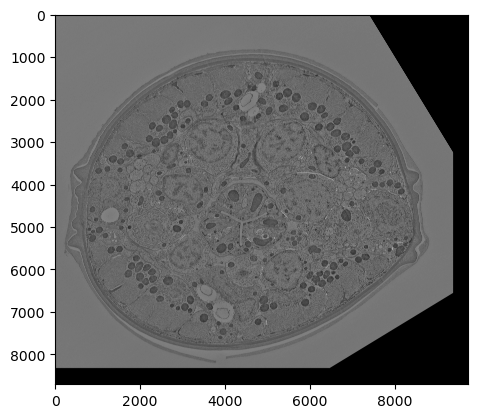

In [ ]:
#Visualize stitching
b = cv2.imread("/home/tommytang111/assembled_results/SEM_dauer_2_image_export_s000_img.png", cv2.IMREAD_GRAYSCALE)
a = cv2.imread("/home/tommytang111/assembled_results/SEM_dauer_2_image_export_s000_pred.png", cv2.IMREAD_GRAYSCALE)
plt.figure(1)
plt.imshow(b, cmap="gray")
plt.imshow(a, cmap="gray", alpha=0.4)
plt.savefig("/home/tommytang111/outputs/SEM_dauer_2_image_export_s000_overlay.png", dpi=1500)
#np.any(a != 0)

### Preprocessing: Quality check images before training

In [ ]:
def is_blurry(image_path, threshold=250):
    """
    Check if an image is blurry using the Laplacian variance method. Can tune threshold to adjust sensitivity. 
    Current threshold of 400 is a good default for SEM images.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Cannot read image: {image_path}")
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var < threshold

#Test (Want to keep img1 and img4):
img1= '/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs/SEM_adult_image_export_s250_part1.png' #Sharp
img2= '/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s110-119/imgs/SEM_dauer_2_export_s110_Y0_X0.png' #Black
img3= '/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s110-119/imgs/SEM_dauer_2_export_s110_Y0_X7.png' #Pure Noise
img4 = '/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs/SEM_adult_image_export_s208_part2.png' #Artifacts present
img5 = '/home/tommytang111/gap-junction-segmentation/Figures/high_artifact_example.png' #Much more artifacts
image_files = [img1, img2, img3, img4, img5]
sharp_images = [img for img in image_files if not is_blurry(img)]
sharp_images

['/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s250-259/imgs/SEM_adult_image_export_s250_part1.png',
 '/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s110-119/imgs/SEM_dauer_2_export_s110_Y0_X7.png',
 '/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/imgs/SEM_adult_image_export_s208_part2.png']

Variance of Laplacian: 221.8500172728527


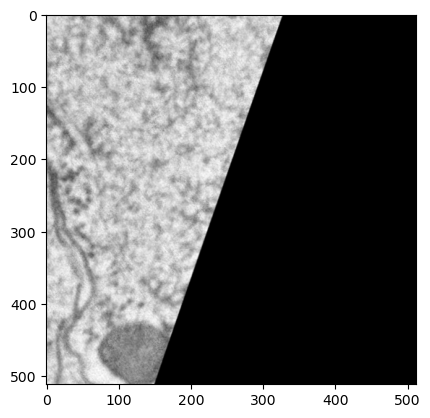

In [45]:
from resize_image import resize_image

#Show Laplacian
#b = resize_image('/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s000-050/imgs/SEM_dauer_2_export_s001_Y0_X18.png', 512, 512, pad_clr=(112,112,112), channels=False)
b=cv2.imread('/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/imgs/SEM_dauer_2_image_export_s034_Y9_X15.png', cv2.IMREAD_GRAYSCALE)
#plt.imshow(cv2.Laplacian(b, cv2.CV_64F), cmap='gray')
plt.imshow(b, cmap='gray')
print(f"Variance of Laplacian: {cv2.Laplacian(b, cv2.CV_64F).var()}")


In [49]:
img = Image.open('/home/tommytang111/gap-junction-segmentation/SEM_adult_image_export_s309.png')
upper_left = img.crop((0,0,512,512))
upper_left.save('/home/tommytang111/gap-junction-segmentation/Figures/high_artifact_example.png')

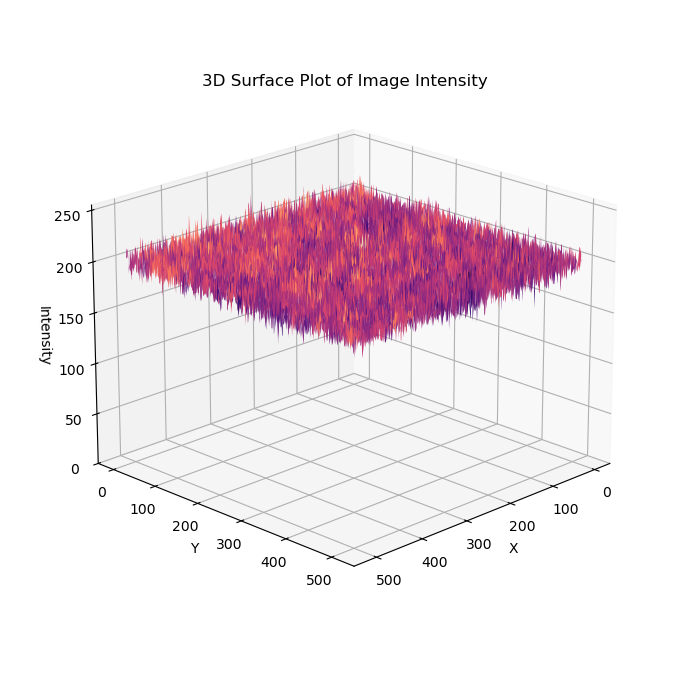

In [36]:
from mpl_toolkits.mplot3d import Axes3D 

#Visualize image as a 3D surface plot
# Load image as grayscale
img = cv2.imread('/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s110-119/imgs/SEM_dauer_2_export_s110_Y0_X7.png', cv2.IMREAD_GRAYSCALE)

# Create X, Y coordinate arrays
X, Y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

# Plot the surface
surface = ax.plot_surface(X, Y, img, cmap='magma')
ax.set_title('3D Surface Plot of Image Intensity', y=0.95)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')
ax.set_zlim(0, 255)
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(elev=20, azim=45)
#colorbar modifiers
#surface.set_clim(0, 255)  # Set color limits for the surface
#cbar_ax = fig.add_axes([0.8, 0.35, 0.02, 0.3])  
#fig.colorbar(surface, cax=cbar_ax)
plt.tight_layout()
plt.show()

In [ ]:
#Get laplassian variance
img = '/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/imgs/SEM_dauer_2_image_export_s001_Y10_X10.png'
a = cv2.Laplacian(cv2.imread(img, cv2.IMREAD_GRAYSCALE), cv2.CV_64F).var()
a

np.float64(365.04546530521475)

In [44]:
#Check through all images the laplassian variances
count = 0
folder = '/mnt/e/Mishaal/sem_dauer_2/jnc_only_dataset_test/imgs'

for img in os.listdir(folder):
    if is_blurry(os.path.join(folder, img)):
        print(f"Image {img} is blurry.")
        count += 1

print(f"Total blurry images: {count}")

Image SEM_dauer_2_image_export_s034_Y9_X15.png is blurry.
Total blurry images: 1


In [23]:
len(os.listdir('/home/tommytang111/gap-junction-segmentation/data/sem_dauer_2/SEM_split/s000-050/imgs'))

16150

In [ ]:
#def filter_images():

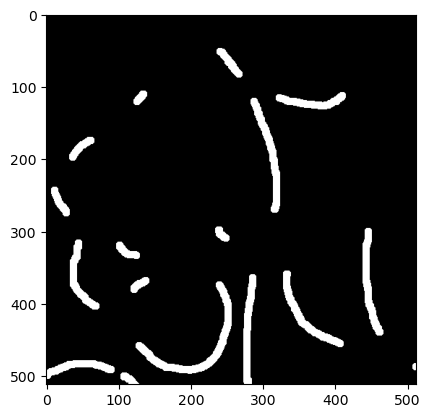

In [ ]:
#Show a sample image
import matplotlib.pyplot as plt
a = cv2.imread("/home/tommytang111/gap-junction-segmentation/data/sem_adult/SEM_split/s200-209/gts/SEM_adult_image_export_s200_part1_label.png", cv2.IMREAD_GRAYSCALE)
#a = a*255
a[a != 0] = 255
plt.imshow(a, cmap='gray')

### Filter out pixels annotated in error

In [3]:
import numpy as np
from scipy.ndimage import label

def filter_pixels(img) -> np.ndarray:
    """
    Changes all non-zero pixel islands in an image to zero if they are less than 8 pixels in size. Designed for greyscale images.
    """
    # Create a copy to avoid modifying the original during iteration
    filtered = img.copy()
    # Label connected components (8-connectivity)
    structure = np.ones((3, 3), dtype=int)
    labeled, num_features = label(img > 0, structure=structure)
    # For each pixel, check if its component has at least 8 pixels
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if img[y, x] != 0:
                component_label = labeled[y, x]
                if component_label == 0:
                    filtered[y, x] = 0
                    continue
                # Count pixels in this component
                count = np.sum(labeled == component_label)
                if count < 8:
                    filtered[y, x] = 0
    return filtered

Case 1: One non-zero pixel
Image is non-zero: True
After filtering, image is non-zero: False 

Case 2: 8 pixels in a line
Image is non-zero: True
After filtering, image is non-zero: True


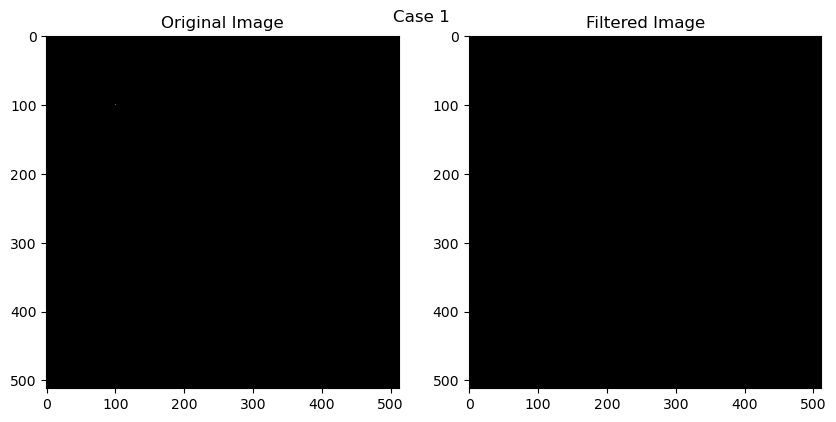

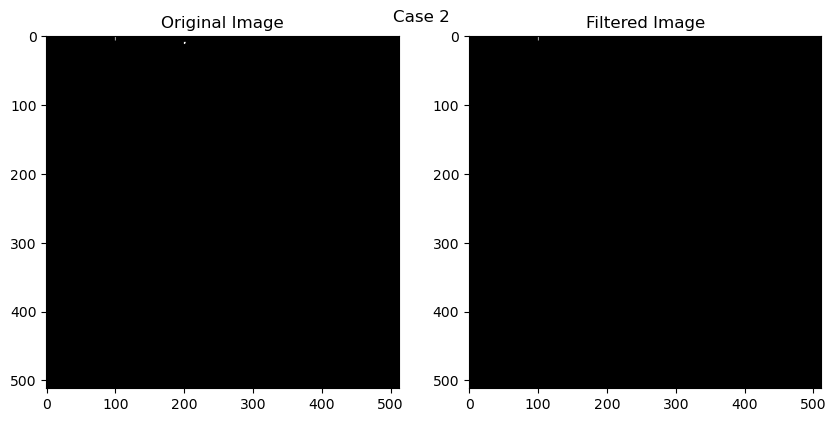

In [ ]:
#Test filter_pixels function
a = np.zeros((512, 512), dtype=np.uint8)

#Case 1: One non-zero pixel
a[100, 100] = 255
plt.figure(1, figsize=(10, 5))
plt.suptitle('Case 1', y=0.9)
plt.subplot(121)
plt.title('Original Image')
plt.imshow(a, cmap='gray')
print("Case 1: One non-zero pixel")
print(f"Image is non-zero: {np.any(a != 0)}")

a = filter_pixels(a)
plt.subplot(122)
plt.title('Filtered Image')
plt.imshow(a, cmap='gray')
print(f"After filtering, image is non-zero: {np.any(a != 0)} \n")

#Case 2: 8 pixels in a line
a[0:8, 100] = 255
# a[10:13, 200] = 255
# a[10:13, 201] = 255
# a[10:11, 202] = 255

plt.figure(2, figsize=(10, 5))
plt.suptitle('Case 2', y=0.9)
plt.subplot(121, )
plt.title('Original Image')
plt.imshow(a, cmap='gray')
print("Case 2: 8 pixels in a line")
print(f"Image is non-zero: {np.any(a != 0)}")

a = filter_pixels(a)
plt.subplot(122)
plt.title('Filtered Image')
plt.imshow(a, cmap='gray')
print(f"After filtering, image is non-zero: {np.any(a != 0)}")


In [7]:
#Check if all images are 512x512
from pathlib import Path
count = 0
root_folder = "/home/tommytang111/data/sem_adult/SEM_split/s250-259"

for folder in os.listdir(root_folder):
    for img in os.listdir(Path(root_folder) / folder):
        read_img = cv2.imread(Path(root_folder) / folder / img, cv2.IMREAD_GRAYSCALE)
        count += 1 if read_img.shape != (512, 512) else 0

count
        

0

In [12]:
#Training on sections 250-259 and validating on sections 200-209 
!python3 unet.py \
--dataset new \
--batch_size 8 \
--focal \
--epochs 100 \
--model_name 2d_gd_mem_run1_model5_epoch149.pk1

ARGS:  ['unet.py', '--dataset', 'new', '--batch_size', '8', '--focal', '--epochs', '100', '--model_name', '2d_gd_mem_run1_model5_epoch149.pk1']
Data loaders created.
Current dataset new
wandb: Currently logged in as: tommytang111 (tommytang111-lunenfeld-tanenbaum-research-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.10
wandb: Run data is saved locally in /home/tommytang111/wandb/wandb/run-20250523_171226-joorrbte
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hardy-serenity-4
wandb: ⭐️ View project at https://wandb.ai/tommytang111-lunenfeld-tanenbaum-research-institute/gap-junction-segmentation
wandb: 🚀 View run at https://wandb.ai/tommytang111-lunenfeld-tanenbaum-research-institute/gap-junction-segmentation/runs/joorrbte
Starting training...
SAVING MODELS TO /home/tommytang111/modelsfocal0
running for 100 epochs
Using device: cuda
100%|█| 5/5 [00:06<00:00,  1.13it/s, loss=Loss: 0.261559